In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

from hyperopt import STATUS_OK, hp, fmin, tpe, Trials, space_eval

import math

*Prediction 9: RMSE-validation: 0.72545.
Optimal theta: 16, lambda: 1.1921e-07 Public LB: 0.67536 base_kp.^[2:4]

In [2]:
# Import data
def load_data():
    full_data = pd.read_csv("X.csv")
    train_y = pd.read_csv("ytr.csv")
    # Rename columns to something more interpretable
    columns = (["reflectance_" + str(i) for i in range(7)]
               + ["solar_" + str(i) for i in range(5)] + ["id"])
    full_data.columns = columns
    
    # Move ID column to the beginning
    id_column = full_data["id"]
    full_data.drop(labels=["id"], axis=1, inplace = True)
    full_data.insert(0, "id", id_column)
    # Add y to the data frame
    split = 98000
    y_id_dict = train_y.set_index("Id")["y"].to_dict()
    full_data.loc[:(split-1), "y"] = full_data.loc[:(split-1), "id"].map(y_id_dict)

    train, test = full_data[:split], full_data[split:]
    return (train, test)


train, test = load_data()

# Parameters
n_threads = -1
random_seed = 8888

### Preprocessing

In [3]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]

# Standardise data for LR
train[cols_orig] = scale(train[cols_orig])
test[cols_orig] = scale(test[cols_orig])

### Data generation for MATLAB

In [4]:
#full_data = full_data.fillna(0)

#cols_excl = ["id", "y"]
#cols_orig = [c for c in full_data.columns if c not in cols_excl]

# Standardise data for LR
#full_data[cols_orig] = scale(full_data[cols_orig])

# I did standardise the data
#full_data.to_csv("aerosol_full.csv", encoding="utf-8", index=False, header=False)

### Python mean embedding

In [ ]:
# don't run
def mean_embedding(X1, X2, kernel):
    k = Kernel(kernel)
    gram_mat = k.gram_matrix2(X1, X2)
    # Number of instances in the bag
    N = float(gram_mat.shape[0])
    mu_X1_X2 = gram_mat.ravel().sum() / N**2
    return (mu_X1_X2)

nb_bag = 200#train["id"].nunique()
K_matrix = np.zeros((nb_bag, nb_bag))

theta = 10**(-8)
for i in range(nb_bag):
    for j in range(nb_bag):
        # Compute mean embedding
        X1 = train.loc[train["id"] == (i+1), cols_orig].values
        X2 = train.loc[train["id"] == (j+1), cols_orig].values
        
        K_matrix[i, j] = mean_embedding(X1, X2, {'name': 'invmquadr','c': theta})

y_train = train["y"].unique()[:200].reshape((-1, 1))
l2_reg = 10**(-8)

y_hat = []
test_id_list = np.arange(980, 1100, dtype=int)

for test_id in test_id_list:
    K_test = np.zeros((1, nb_bag))

    for j in range(nb_bag):
        X1 = train.loc[train["id"] == (j+1), cols_orig].values
        X2 = test.loc[test["id"] == test_id, cols_orig].values
        K_test[0, j] = mean_embedding(X1, X2, {'name': 'invmquadr','c': theta})

    # Ridge regression
    ridge_mat = K_matrix + (l2_reg * nb_bag) * np.identity(nb_bag)
    ridge_mat_inv = np.linalg.solve(ridge_mat, np.identity(nb_bag))
    y_hat.append((K_test.dot(ridge_mat_inv)).dot(y_train)[0, 0])

y_hat = np.array(y_hat)

np.sqrt(mean_squared_error(y_hat, test["y"].unique()[:120]))

### Ridge regression

In [5]:
# Class for ridge regression
class RidgeRegression(object):
    def __init__(self, l2_reg):
        self.l2_reg = l2_reg

    def fit(self, G, y):
        # Train size
        L_train = G.shape[0]
        # Add the validation set later
        ridge_mat = G + (self.l2_reg * L_train) * np.identity(L_train)
        self.ridge_mat = ridge_mat
        # Shape of y_train is (1, L_train)
        self.y_train = y

    def predict(self, G_test):
        y_test_hat = self.y_train.dot(np.linalg.solve(self.ridge_mat, G_test))
        return y_test_hat

In [6]:
# Root mean squared error metric
def RMSE(y, y_hat):
    out = np.sqrt(mean_squared_error(y.reshape((-1,)), y_hat.reshape((-1,))))
    return (out)

### Set up

In [7]:
random_seed = 8
n_folds = 5 # set folds for out-of-fold prediction
# In KFold, random_state will only be used if shuffle is set to True
kf = KFold(n_splits=n_folds, shuffle=False, random_state=random_seed)

### Out-of-fold predictions

In [8]:
# G_train and G_test are pandas dataframes
# lr is a ridge regression
def oof_prediction(lr, G_train, y_train, G_test):
    n_train = G_train.shape[0]
    n_test = G_test.shape[1]
    oof_train = np.zeros((n_train,))
    oof_test = np.zeros((n_test,))
    oof_test_folds = np.zeros((n_folds, n_test))

    for i, (train_index, test_index) in enumerate(kf.split(G_train)):
        G_tr = G_train.loc[train_index, train_index].values
        y_tr = y_train[train_index].reshape((1, -1))
        G_te = G_train.loc[train_index, test_index].values

        lr.fit(G_tr, y_tr)
        oof_train[test_index] = lr.predict(G_te)
        G_test_partial = G_test.loc[train_index, :]
        oof_test_folds[i, :] = lr.predict(G_test_partial.values)

    oof_test = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### First base predictors

* __Cauchy__: theta: 16, lambda: 2**(-23)
* __Matern3/2__: theta: 512, lambda: 2**(-33)
* __Matern5/2__: theta: 64, lambda: 2**(-31)
* __Rational quadratic__: theta: 512, lambda: 2**(-26)

In [9]:
nb_bags_train = 980
# Create a vector with the unique values of y for each ID.
y_train = train.groupby("id")["y"].median().values

In [10]:
def load_gram(csv_file, nb_bags_train):
    # Import data
    G = pd.read_csv(csv_file, header=None)
    idx_train = nb_bags_train - 1
    idx_test = nb_bags_train
    G_train = G.loc[:idx_train, :idx_train]
    G_test = G.loc[:idx_train, idx_test:]
    return (G_train, G_test)

In [11]:
# Define models and import Gram matrices
# Cauchy
l2_reg_cauchy = 2**(-23)
cauchy = RidgeRegression(l2_reg_cauchy)
G_train_cauchy, G_test_cauchy = load_gram("Cauchy_16.csv", nb_bags_train)

# Matern 3/2 -> removed as it gave inferior results
#l2_reg_matern_32 = 2**(-37)
#matern_32 = RidgeRegression(l2_reg_matern_32)
#G_train_matern_32, G_test_matern_32 = load_gram("Matern_32_1024.csv", nb_bags_train)

# Matern 5/2
l2_reg_matern_52 = 2**(-36) # to change + csv name
matern_52 = RidgeRegression(l2_reg_matern_52)
G_train_matern_52, G_test_matern_52 = load_gram("Matern_52_128.csv", nb_bags_train)

# Rational quadratic
l2_reg_rquadr = 2**(-28) # to change + csv name
rquadr = RidgeRegression(l2_reg_rquadr)
G_train_rquadr, G_test_rquadr = load_gram("rquadr_1024.csv", nb_bags_train)

In [12]:
# Create our OOF train and test predictions. These base results will be used as new features.
# Cauchy
cauchy_oof_train, cauchy_oof_test = oof_prediction(cauchy, G_train_cauchy, 
                                                   y_train, G_test_cauchy)
# Matern 3/2
#matern_32_oof_train, matern_32_oof_test = oof_prediction(matern_32, G_train_matern_32, 
 #                                                        y_train, G_test_matern_32)
# Matern 5/2
matern_52_oof_train, matern_52_oof_test = oof_prediction(matern_52, G_train_matern_52, 
                                                         y_train, G_test_matern_52)
# Rational quadratic
rquadr_oof_train, rquadr_oof_test = oof_prediction(rquadr, G_train_rquadr, 
                                                   y_train, G_test_rquadr)
print("Training is finished.")

Training is finished.


In [13]:
RMSE(cauchy_oof_train, y_train)

0.67685885815701352

In [14]:
#RMSE(matern_32_oof_train, y_train)

In [15]:
RMSE(matern_52_oof_train, y_train)

0.68275251697962624

In [16]:
RMSE(rquadr_oof_train, y_train)

0.67635136601886747

### Second level prediction with DNN

In [17]:
kernel_train = pd.DataFrame({'cauchy': cauchy_oof_train.ravel(),
                             #'matern_32': matern_32_oof_train.ravel(),
                             'matern_52': matern_52_oof_train.ravel(),
                             'rquadr': rquadr_oof_train.ravel()})

kernel_train["y"] = y_train

kernel_test = pd.DataFrame({'cauchy': cauchy_oof_test.ravel(),
                            #'matern_32': matern_32_oof_test.ravel(),
                            'matern_52': matern_52_oof_test.ravel(),
                            'rquadr': rquadr_oof_test.ravel()})

cols_excl_kernel = ["y"]
cols_kernel = [c for c in kernel_train.columns if c not in cols_excl_kernel]

kernel_train.head()

,cauchy,matern_52,rquadr,y
0,-3.607706,-3.492275,-3.534167,-3.998082
1,-4.315562,-4.342068,-4.355062,-4.137141
2,-2.688123,-2.675943,-2.657661,-2.694732
3,-3.377650,-3.449581,-3.443466,-3.296275
4,-3.717942,-3.701184,-3.693895,-3.181391


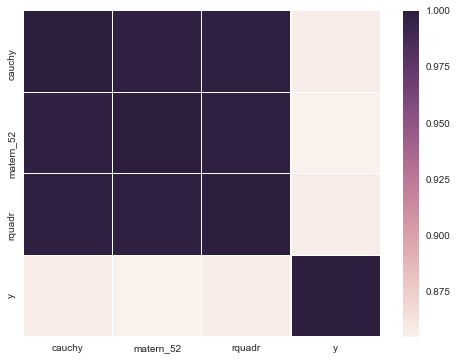

In [20]:
# Check predictions correlation
corr_matrix = kernel_train.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, linewidths=0.2, ax=ax)

### Cross-validation for MLPRegressor

In [26]:
def scoring_function(parameters):
    print("Training the model with parameters: ")
    print(parameters)
    average_RMSE = 0.0
    n_splits = 5
    
    kf = KFold(n_splits=n_splits)
    nb_fold = 0
    for train_index, validation_index in kf.split(kernel_train):
        nb_fold += 1
        train_fold, validation_fold = kernel_train.loc[train_index], kernel_train.loc[validation_index]

        #MPL Regressor
        model_dnn = MLPRegressor(hidden_layer_sizes=(parameters["nb_neurons"],),
                                 max_iter=parameters["steps"],
                                 alpha=parameters["MLP_l2_reg"],
                                 early_stopping=True,
                                 random_state=random_seed)
        model_dnn.fit(train_fold[cols_kernel], train_fold["y"])
        y_hat_train = model_dnn.predict(train_fold[cols_kernel])

        RMSE_train = RMSE(y_hat_train, train_fold["y"].values)
        print("Training RMSE: {0}".format(RMSE_train))

        y_hat_test = model_dnn.predict(validation_fold[cols_kernel])

        RMSE_test = RMSE(y_hat_test, validation_fold["y"].values)
        
        average_RMSE += RMSE_test
        print("Validation fold {0} RMSE: {1}".format(nb_fold, RMSE_test))

    average_RMSE /= n_splits

    print("Cross-validation score: {0}\n".format(average_RMSE))
    
    return {"loss": average_RMSE, "status": STATUS_OK}

In [43]:
# Grid to pick parameters from.
parameters_grid = {"steps"             : hp.choice("steps", np.arange(1000, 1100, 100, dtype=int)),
                   "nb_neurons"      : hp.choice("nb_neurons", np.arange(10, 11, 1, dtype=int)),
                   "MLP_l2_reg": hp.choice("MLP_l2_reg", np.power(2.0, np.arange(-9, -5)))
                  }
# Record the information about the cross-validation.
trials = Trials()

best = fmin(scoring_function, parameters_grid, algo=tpe.suggest, max_evals=10, 
            trials=trials)

Training the model with parameters: 
{'MLP_l2_reg': 0.00390625, 'steps': 1000, 'nb_neurons': 10}
Training RMSE: 0.686387403693
Validation fold 1 RMSE: 0.627589188736
Training RMSE: 0.673979872265
Validation fold 2 RMSE: 0.663013328256
Training RMSE: 0.66515817709
Validation fold 3 RMSE: 0.705848993376
Training RMSE: 0.689029997789
Validation fold 4 RMSE: 0.646774949387
Training RMSE: 0.665400716024
Validation fold 5 RMSE: 0.735286281633
Cross-validation score: 0.675702548278

Training the model with parameters: 
{'MLP_l2_reg': 0.001953125, 'steps': 1000, 'nb_neurons': 10}
Training RMSE: 0.686015866456
Validation fold 1 RMSE: 0.625964692048
Training RMSE: 0.674055077929
Validation fold 2 RMSE: 0.663578805735
Training RMSE: 0.665150978438
Validation fold 3 RMSE: 0.705870709249
Training RMSE: 0.689053761664
Validation fold 4 RMSE: 0.646775790196
Training RMSE: 0.667385288618
Validation fold 5 RMSE: 0.736884682983
Cross-validation score: 0.675814936042

Training the model with parameters: 

In [34]:
min(trials.losses())

0.6739617355611843

In [31]:
# Save the best parameters as a csv.
best_parameters = pd.DataFrame({key: [value] for (key, value) in 
                                zip(space_eval(parameters_grid, best).keys(),
                                    space_eval(parameters_grid, best).values())})
# Add the corresponding score.
best_parameters["score"] = min(trials.losses())
best_parameters.to_csv("best_parameters_10.csv", encoding="utf-8", index=False)

best_parameters

,MLP_l2_reg,nb_neurons,steps,score
0,0.00941,10,1000,0.673803


### Prediction

In [22]:
#MPL Regressor
best_parameters = pd.read_csv("best_parameters_10.csv", encoding="utf-8")

model_dnn = MLPRegressor(hidden_layer_sizes=(best_parameters["nb_neurons"][0]),
                         max_iter=best_parameters["steps"][0],
                         alpha=best_parameters["MLP_l2_reg"][0],
                         early_stopping=True,
                         random_state=random_seed)
model_dnn.fit(kernel_train[cols_kernel], y_train)

MLPRegressor(activation='relu', alpha=0.00941, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=8, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [23]:
# Training error
RMSE(model_dnn.predict(kernel_train[cols_kernel]), y_train)

0.67428005689905501

In [24]:
# Prediction
y_hat_test = model_dnn.predict(kernel_test[cols_kernel])

test_pred = test.groupby("id")[["y"]].mean().reset_index()
test_pred["y"] = y_hat_test
test_pred.columns = ["Id", "y"]

In [25]:
# Save as a .csv
test_pred.to_csv("Prediction_10.csv", index=False)